# MNIST handwritten-digit supervised learning

## Overview:
    - Read in training ubyte file
    - Explore raw dataset
    - Outlier removal / imputation
    - Feature aggregation / preprocessing
    - Dimensionality reduction
    - Training
    - Evaluation

*Import libraries*

In [1]:
import pandas as pd
import bottleneck
import numexpr
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import struct # for handling C data structures
%matplotlib inline

rng = np.random.seed(42)

*Import data*

In [2]:
f = open('./data/train-labels.idx1-ubyte', "rb") # handle for the label file
_, data_length = struct.unpack('>II', f.read(8)) 
# struct allows python to read in C data structures: I = unsig int, > = Big-endian, f.read(...) is formatted string
y = [struct.unpack('b', f.read(1))[0] for _ in range(0, data_length)]

In [3]:
f = open('./data/train-images.idx3-ubyte', 'rb')
_, _, nrows, ncols = struct.unpack('>IIII', f.read(16))
npx = nrows*ncols
X = [[struct.unpack('>B', f.read(1))[0] for _ in range(npx)] for _ in range(data_length)]

*Extract a subset of the data*

In [89]:
X_sub = np.array(X[0:20000])
y_sub = y[0:20000]

*Display example images*

In [138]:
def display_images(img_arr, count=10):
    f, ax = plt.subplots(ncols=count, figsize=(16, 5))
    for i, j in enumerate(np.random.randint(0, len(img_arr), size=count)):
        img = np.reshape(a=img_arr[j], newshape=[28, 28])
        ax[i].imshow(img, cmap='gray')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    plt.show()

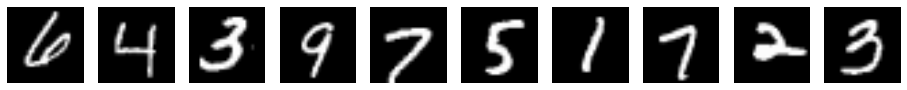

In [91]:
display_images(X_sub)

*Verify that responses are balanced*

In [92]:
np.sort(np.bincount(y_sub)) # They're balanced enough for now - possibly later we can over-sample the depleted ones

array([1775, 1922, 1929, 1945, 1971, 1994, 2014, 2076, 2093, 2281], dtype=int64)

*Feature engineering*

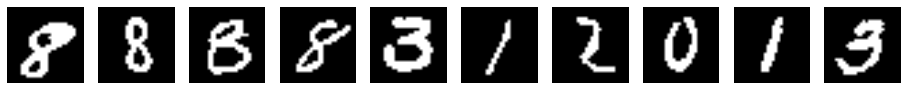

In [93]:
# Convert grayscale to BW
X_sub_bw = np.floor(2*X_sub/255.001)
display_images(X_sub_bw)

In [94]:
def centre_image(tx_arr):
    # Centre characters in image frame
    # Compute character centroids
    px_posn = [i for i in range(len(tx_arr))]
    col_centroid = int((px_posn*tx_arr.sum(axis=0)).sum()/tx_arr.sum())# returns centroid pixel for columns
    row_centroid = int((px_posn*tx_arr.sum(axis=1)).sum()/tx_arr.sum())# returns centroid pixel for rows
    # Roll image so that the centroid coincides with the frame's centre
    centre = int(np.ceil(len(tx_arr)/2)) # index of central pixel of the image
    roll_cols = centre - col_centroid
    roll_rows = centre - row_centroid
    tx_arr = np.roll(tx_arr, shift=roll_cols, axis=1)
    tx_arr = np.roll(tx_arr, shift=roll_rows, axis=0)
    return tx_arr

In [111]:
# Centre image
X_sub_centered = np.array([centre_image(np.reshape(image, [28, 28])).flatten() for image in X_sub_bw])

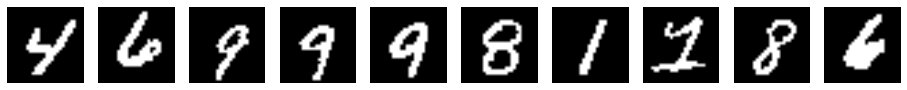

In [112]:
display_images(X_sub_centered)

In [150]:
# dilated image
import cv2
kernel = np.ones([2, 2], np.uint8)
X_sub_dilated = np.array([cv2.dilate(np.reshape(img, [28, 28]), kernel, iterations=1).flatten() for img in X_sub_centered])

In [165]:
# closing image
kernel = np.ones([1, 1], np.uint8)
X_sub_closed = np.array([cv2.morphologyEx(np.reshape(img, [28, 28]), cv2.MORPH_CLOSE, kernel).flatten() for img in X_sub_centered])

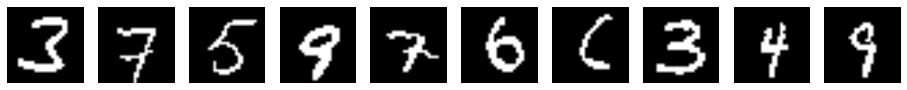

In [166]:
display_images(X_sub_closed)

*Split data into a training and a testing set*

In [167]:
from sklearn.cross_validation import train_test_split, cross_val_predict
X_train, X_test, y_train, y_test = train_test_split(X_sub_closed, y_sub)

# Normalise data
from sklearn.preprocessing import scale
scale(X_train, copy=False);

*Dimensionality reduction*

Dimensionality reduction is necessary here because the classifiers will take a long time to fit otherwise. The reason for this is that when a classifier, say logistic regression, requires each coefficient to be optimised in maximizing the maximum likelihood function. Optimising more coefficients will take longer, so a dataset with fewer features is preferable in the absence of more computing power.

The first dimensionality reduction we will try is principal component analysis (PCA). PCA creates composite features that capture as much variance within the original features as possible. It does this by 

In [168]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
X_train_pc = pca.fit_transform(X_train)

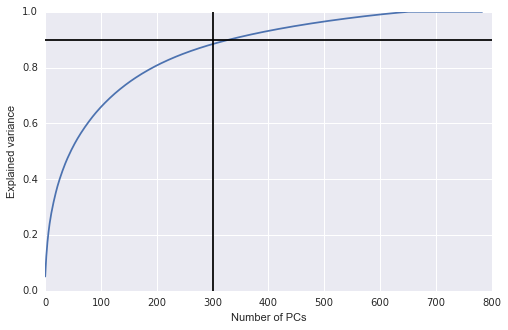

In [169]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_)/sum(pca.explained_variance_))
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance')
plt.axhline(0.90, color='k')
plt.axvline(300, color='k');

In [170]:
# Extract first 300 principal components
X_train_pc = [image[0:300] for image in X_train_pc]

*Multiple logistic regression*

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr = LogisticRegression()

In [129]:
lr.fit(X_train_pc, y_train)
y_train_predictions = lr.predict(X_train_pc);

*Evaluate training performance*

In [130]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_predictions)

0.91073333333333328

This high an accuracy score can be attributed to overfitting. Using k-fold cross-validation will alleviate this problem. K-fold cross-validation involves splitting the training data into $k$ "folds", training the model separately on all folds but one, repeating this procedure such that each fold is the testing fold, then taking the average mean squared error (or error rate) as an estimate of the model's true mean squared error. 

K-fold cross-validation generally provides a better estimate of the true MSE because the models estimates are not informed by the data they're evaluated against, as was the case above. Additionally, k-fold cross-validation accounts for the variance of a model's fit (i.e. how much the model would change when fit on different sets of data from the same underlying process): by taking the average error rate across many fits, it's possible to get a better estimate of the true error. Bias is the error introduced to our estimates by using a simpler-than-life model of the relationship. K-fold cross validation has a higher bias than LOOCV (leave-one-out cross-validation) because the models trained are fit to a smaller sample of data, and are consequently of a slightly worse fit.

$$\text{MSE} = \frac{\text{RSS}}{n}$$ 

Where $n$ is the number of observations.

In [131]:
from sklearn.cross_validation import cross_val_score

In [132]:
cv_scores = cross_val_score(lr, X_train_pc, y_train, scoring='accuracy')
cv_scores

array([ 0.9018785 ,  0.8956    ,  0.90172138])

A good fit - but there are several questions to answer if we want to understand how the model is making its predictions.
- Which are the most valuable pixels in predicting an image's class and why?
- Are there any common characteristics between misclassified images that might explain why the prediction fails?

*Which pixels are most valuable in predicting an image's class?*

To answer this question, we could look at the classifier's coefficients. Each coefficient corresponds to the change in the log-odds for a symbol's class per unit change in a pixel's value: a larger value indicates that a pixel is a stronger indicator of a particular character. This method requires quite a bit of legwork, especially compared to an alternative method: looking at the correlation between the pixels and the response.

In [133]:
# Create one-hot encoded response vector
y_train_ohe = pd.get_dummies(y_train)
corr = [np.reshape(char_px_corrs, [28, 28]) for char_px_corrs in np.corrcoef(X_train, y_train_ohe, rowvar=0)[-10:, :-10]]

import seaborn as sns

f, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))
for i, px_corrs in enumerate(corr):
    sns.heatmap(px_corrs, xticklabels=False, yticklabels=False, cbar=False, ax=ax.flatten()[i]);

C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


ValueError: total size of new array must be unchanged

*Ensemble Adaboost and Random Forest Classification*

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10) # this is identical to using one DT
ab_score = cross_val_score(ab, X_train, y_train, scoring='accuracy')
ab_score

array([ 0.72727273,  0.72938351,  0.6936648 ])

Adaboost - which is ML slang for "Adaptive Boosting" - is an algorithm that predicts the class of a sample by computing the weighted sum of many classifiers predictions.  

A boost classifier has the form 
$$ F_T(x) = \sum_{t=1}^Tf_t(x) $$
where $T$ is the number of weak classifiers used to build the booster. Each $f_t$ is a weak classifier that takes a sample $x_i$ as input and returns a weighted value of the class it thinks the sample belongs to. $f_t(x)$ can be written $\alpha_t h_t(x)$, where $\alpha_t$ is that iteration's weighting, and $h_t(x)$ is the prediction vector. $alpha_t$ is chosen to minimise the AdaBoost classifier's sum error when that iteration's classifier is included in the model:

$$ E_t = \sum_i E[F_{t-1}(x_i) + \alpha_t h(x_i)] $$

Notice that this is a greedy algorithm - it always opts for the steepest path nearby, which may not result in the lowest error result globally.

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [171]:
rf_score = cross_val_score(RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced'), X_train, y_train)
rf_score

array([ 0.94325674,  0.94557823,  0.95097058])

*Support vector machines (non-linear decision boundaries)*

In [30]:
from sklearn import svm

# nC2 classifiers are trained for an n-class problem when using SVC() - one-vs-one decision boundaries are fitted
# 10c2 = 45 classifiers
# LinearSVC implements a one-vs-rest strategy, which means that only n boundaries are fitted.

In [88]:
# linear SVC
lsvc = svm.LinearSVC()
cross_val_score(lsvc, X_train, y_train)

array([ 0.87291271,  0.8838    ,  0.87878788])

In [ ]:
# Bagging does not require cross-validation, as only about 2/3 of samples are used to fit each of the classifiers - for 
# classification, bagging uses the majority vote to predict the response for a given sample. The samples that aren't used
# to fit a weak learner in bagging are known as 'out-of-bag' observations.

In [ ]:
# Optimised RandomForestClassifier
# What can we optimise?

In [ ]:
# Support vector machines
# -> can refer to support vector classfier, maximal margin classifier, and the support vector machine

# Hyperplane
# ----------
# In p-dimensional space, a hyperplane is a flat affine subspace of dimension p-1.
# E.g. in 2D a hyperplane is a line
# Mathematically, a hyperplane is defined by the equation (in p dimensions):
# B0 + B1X1 + B2X2 + ... +BpXp = 0
# E.g. for 2d: B0 + B1X1 + B2X2 = 0 (a linear equation)
# A hyperplane separates two regions of space by the fact that any X = (X1 X2 X3... )T will almost certainly lie above
# or below the hyperplane - that is, substituting X into the hyperplane equation will result in gt or lt zero.
# 'Affine subspace' -> a subspace that doesn't have to pass through the origin.

# The hyperplane is chosen such that observations of one class lie on one side of it, whereas observations of another
# class lie on the other. The distance of an observation from the hyperplane indicates how sure we are that an observation
# belongs to a class.

# An infinite number of hyperplanes exist.
# How to choose the best one?
# We're trying to be as accurate and as confident as possible in our predictions.
# It is therefore natural that we want to choose a plane for which observations of different classes are as far away
# from the decision boundary as possible. Consequently, the optimal choice of hyperplane is the one that maximises
# the distance of all training observations from it. More specifically, the optimal choice of plane is as far away from
# the nearest training sample as possible. The distance to this training sample is known as the 'margin'. A classifying
# hyperplane that's as far from this nearest observation as possible is known as a 'maximal margin classifier'.
# This classifier can be overfit when the number of features is large (curse of dimensionality), or when the number
# of samples is small (these things are the same)
# The support vectors are the

# Support vector classifier == soft margin classifier